<a href="https://colab.research.google.com/github/alirezash97/Cardio/blob/master/HeartBeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"alirezashafaei97","key":"9cb262aa0c5658ffc4eb45857c41903c"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d shayanfazeli/heartbeat -p /content
!unzip /content/heartbeat.zip -d /content/heartbeat

In [112]:
import pandas as pd
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import (Input, Dense, LeakyReLU, Softmax, InputLayer, concatenate, Conv1D, MaxPool1D, Add
 , Flatten, Dropout, ReLU, BatchNormalization, GlobalAveragePooling1D)
from keras.utils.np_utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from random import uniform 
import random


from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix


Using TensorFlow backend.


In [0]:
train_df=pd.read_csv('/content/heartbeat/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/heartbeat/mitbih_test.csv',header=None)

In [109]:
train_df[187]=train_df[187].astype(int)
counter=train_df[187].value_counts()
print(counter)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [0]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [0]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [114]:
equilibre=train_df[187].value_counts()
print(equilibre)

4    20000
3    20000
2    20000
1    20000
0    20000
Name: 187, dtype: int64


In [115]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
20149,1.000000,0.823529,0.620321,0.334225,0.208556,0.128342,0.120321,0.165775,0.195187,0.237968,0.237968,0.141711,0.125668,0.254011,0.427807,0.526738,0.540107,0.529412,0.481283,0.449198,0.443850,0.422460,0.406417,0.398396,0.406417,0.454545,0.454545,0.465241,0.489305,0.513369,0.508021,0.532086,0.524064,0.516043,0.478610,0.475936,0.427807,0.393048,0.385027,0.339572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
74314,0.911340,0.954639,0.486598,0.053608,0.032990,0.088660,0.109278,0.109278,0.092784,0.090722,0.094845,0.088660,0.084536,0.080412,0.076289,0.076289,0.070103,0.059794,0.051546,0.053608,0.043299,0.035052,0.032990,0.030928,0.024742,0.026804,0.043299,0.057732,0.061856,0.070103,0.096907,0.117526,0.129897,0.136082,0.160825,0.156701,0.152577,0.152577,0.150515,0.144330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
78634,0.763780,0.840551,0.805118,0.724409,0.688976,0.653543,0.685039,0.700787,0.584646,0.301181,0.183071,0.125984,0.112205,0.090551,0.090551,0.070866,0.074803,0.055118,0.059055,0.031496,0.035433,0.015748,0.015748,0.000000,0.007874,0.000000,0.011811,0.003937,0.019685,0.033465,0.074803,0.094488,0.149606,0.169291,0.214567,0.218504,0.228346,0.216535,0.222441,0.208661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80699,0.956522,1.000000,0.614625,0.332016,0.221344,0.169960,0.132411,0.116601,0.106719,0.118577,0.083004,0.088933,0.081028,0.055336,0.053360,0.049407,0.033597,0.021739,0.013834,0.007905,0.005929,0.011858,0.000000,0.025692,0.023715,0.047431,0.063241,0.092885,0.124506,0.150198,0.171937,0.166008,0.183794,0.193676,0.187747,0.181818,0.187747,0.177866,0.183794,0.187747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
85126,1.000000,0.501859,0.513011,0.535316,0.539033,0.520446,0.513011,0.531599,0.509294,0.405204,0.260223,0.152416,0.193309,0.174721,0.107807,0.107807,0.092937,0.089219,0.096654,0.078067,0.066914,0.100372,0.107807,0.115242,0.104089,0.107807,0.118959,0.137546,0.122677,0.122677,0.115242,0.122677,0.163569,0.171004,0.156134,0.193309,0.204461,0.223048,0.252788,0.293680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [0]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

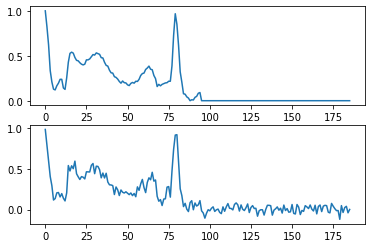

In [119]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [0]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [0]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
#for i in range(len(X_train)):
#    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [0]:
trainset = train_df.values
testset = test_df.values

In [0]:
def split(dataset, number_of_sample_per_category):
  
  new_dataset = np.zeros((np.sum(number_of_sample_per_category), dataset.shape[1]))
  pointer = 0
  
  for row in dataset :
    
    row_label = int(row[-1])
    
    if number_of_sample_per_category[row_label] > 0 :
      
      number_of_sample_per_category[row_label] -= 1
      new_dataset[pointer , :] = row
      pointer += 1

    else:

      pass
    
  
  return new_dataset




In [0]:
temp_trainset = split(trainset, [5500, 2223, 5500, 641, 5500])
temp_testset = split(testset, [500, 500, 500, 500, 500])

In [0]:
augmented = 0
def data_augmentation(dataset, chance):
  
  augmented = 0
  number_of_rows = int(dataset.shape[0] + (dataset.shape[0] * (chance*2)))
  new_dataset = np.zeros((number_of_rows, dataset.shape[1]))
  pointer = 0 

  for row in dataset:
    
    rand_num = random.uniform(0, 1)
    if rand_num < chance:
      
      augmented += 1
      noise = np.random.normal(scale=0.01, size=187)
      new_signal = np.zeros((1, 188))
      new_signal[:, :187] = row[:187] + noise
      new_signal[:, -1:] = row[-1:] 
      new_dataset[pointer:pointer+1, :] = new_signal
      pointer += 1

    else :
      pass

    new_dataset[pointer, :] = row 
    pointer += 1

  return augmented, new_dataset  

  

In [0]:
# augmented, trainset = data_augmentation(temp_trainset, 0.08)

In [0]:
filled = augmented + temp_trainset.shape[0]
trainset = trainset[:filled , :]

In [0]:
trainset = np.take(trainset,np.random.permutation(trainset.shape[0]),axis=0,out=trainset)
testset = np.take(temp_testset,np.random.permutation(temp_testset.shape[0]),axis=0,out=temp_testset)

In [0]:
X_temp_train = trainset[:, :-1]
Y_train = trainset[:, -1:]
X_temp_test = testset[:, :-1]
Y_test = testset[:, -1:]

In [62]:
print("X_train : ", X_temp_train.shape)
print("Y_train : ", Y_train.shape)
print("X_test : ", X_temp_test.shape)
print("Y_test : ", Y_test.shape)

X_train :  (20946, 187)
Y_train :  (20946, 1)
X_test :  (2500, 187)
Y_test :  (2500, 1)


In [107]:

# One Hot enoding for target labels 
ohe = OneHotEncoder()
Y_train = ohe.fit_transform(Y_train.reshape(-1,1))
Y_test = ohe.transform(Y_test.reshape(-1,1))

# handle sparse matrix for keras 
Y_train = csr_matrix.toarray(Y_train)
Y_test = csr_matrix.toarray(Y_test)

ValueError: ignored

In [64]:
print("X_train : ", X_temp_train.shape)
print("Y_train : ", Y_train.shape)
print("X_test : ", X_temp_test.shape)
print("Y_test : ", Y_test.shape)

X_train :  (20946, 187)
Y_train :  (20946, 5)
X_test :  (2500, 187)
Y_test :  (2500, 5)


In [0]:
# periodic signal extend 

# import pywt

# XF_train = np.zeros((X_temp_train.shape[0], 9000))
# XF_test = np.zeros((X_temp_test.shape[0], 9000))


# for index, row in enumerate(X_temp_train):
#   XF_train[index, :-1] = pywt.pad(row, 4406, 'symmetric')
#   XF_train[index, -1:] = 0


# for index, row in enumerate(X_temp_test):
#   XF_test[index, :-1] = pywt.pad(row, 4406, 'symmetric')
#   XF_test[index, -1:] = 0
 



In [0]:
for index, row in enumerate(X_temp_train):
  X_temp_train[index] = add_gaussian_noise(row)
for index, row in enumerate(X_temp_test):
  X_temp_test[index] = add_gaussian_noise(row)


In [0]:
XF_train = X_temp_train.reshape((20946, 187, 1))
XF_test = X_temp_test.reshape((2500, 187, 1))

In [78]:
print("X_train : ", XF_train.shape)
print("Y_train : ", Y_train.shape)
print("X_test : ", XF_test.shape)
print("Y_test : ", Y_test.shape)

X_train :  (20946, 187, 1)
Y_train :  (20946, 5)
X_test :  (2500, 187, 1)
Y_test :  (2500, 5)


In [122]:
im_shape=(X_train.shape[1], 1)
inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
conv1_1=Conv1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
conv1_1=BatchNormalization()(conv1_1)
pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
conv2_1=Conv1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
conv2_1=BatchNormalization()(conv2_1)
pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
conv3_1=Conv1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
conv3_1=BatchNormalization()(conv3_1)
pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
flatten=Flatten()(pool3)
dense_end1 = Dense(64, activation='relu')(flatten)
Drop0 = Dropout(0.5)(dense_end1)
dense_end2 = Dense(32, activation='relu')(Drop0)
main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)

model = Model(inputs=inputs_cnn, outputs=main_output)

model.summary()


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      [(None, 186, 1)]          0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 181, 64)           448       
_________________________________________________________________
batch_normalization_45 (Batc (None, 181, 64)           256       
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 91, 64)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 89, 64)            12352     
_________________________________________________________________
batch_normalization_46 (Batc (None, 89, 64)            256       
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 45, 64)            0  

In [124]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), callbacks=[es_callback])

Epoch 1/20
782/782 [==============================] - 75s 96ms/step - loss: 0.3866 - accuracy: 0.8595 - val_loss: 0.4437 - val_accuracy: 0.8464
Epoch 2/20
782/782 [==============================] - 73s 94ms/step - loss: 0.1866 - accuracy: 0.9329 - val_loss: 0.2054 - val_accuracy: 0.9296
Epoch 3/20
782/782 [==============================] - 73s 94ms/step - loss: 0.1297 - accuracy: 0.9535 - val_loss: 0.1705 - val_accuracy: 0.9405
Epoch 4/20
782/782 [==============================] - 73s 94ms/step - loss: 0.1029 - accuracy: 0.9636 - val_loss: 0.1493 - val_accuracy: 0.9490
Epoch 5/20
782/782 [==============================] - 73s 93ms/step - loss: 0.0857 - accuracy: 0.9698 - val_loss: 0.1317 - val_accuracy: 0.9566
Epoch 6/20
782/782 [==============================] - 74s 94ms/step - loss: 0.0750 - accuracy: 0.9738 - val_loss: 0.1283 - val_accuracy: 0.9610
Epoch 7/20
782/782 [==============================] - 74s 95ms/step - loss: 0.0660 - accuracy: 0.9771 - val_loss: 0.1294 - val_accuracy: